# Dataloader

In [78]:
from pathlib import Path
import numpy as np
from numpy import random
import torch
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
import matplotlib.pyplot as plt

import torch_geometric as tg #.data as data
import networkx as nx
from torch_geometric.utils.convert import to_networkx

from bokeh.palettes import Category20_20
from bokeh.plotting import figure, from_networkx
from bokeh.io import output_notebook, show
output_notebook()

import logging
logger = logging.getLogger(__name__)

Loading BokehJS ...

In [2]:
def _start_logging():
    logging.basicConfig(filename='tests.log', filemode='w', level=logging.INFO, force=True,
                        format='%(asctime)s %(levelname)s %(module)s.%(funcName)s - %(message)s')
    logger.info('Started logging')

    # logger.debug('This is a debug message')
    # logger.info('This is an info message')
    # logger.warning('This is a warning message')
    # logger.error('This is an error message')
    # logger.critical('This is a critical message')
_start_logging()

# Plots

In [3]:
def plot_histograms(arrays, bins=30, figsize=(6, 1), max_height=20, title=None):
    """
    Plot histograms for a list of numpy arrays in a single column.

    Parameters:
    arrays (list of np.array): List of numpy arrays to plot.
    bins (int): Number of bins for the histograms.
    figsize (tuple): Size of the figure. The height is multiplied
        by the number of arrays to plot.
    max_height (int): Maximum height of the figure in inches.
    """
    num_arrays = len(arrays)
    figsize = (figsize[0], min(figsize[1]*(1+num_arrays), max_height))
    _, axes = plt.subplots(num_arrays, 1, figsize=figsize, sharex=True)

    if num_arrays == 1:
        axes = [axes]

    for i, data_ in enumerate(arrays):
        axes[i].hist(data_, bins=bins, edgecolor='black')
        axes[i].set_ylabel('Freq.')

    if title is not None:
        axes[0].set_title(title)

    axes[-1].set_xlabel('Value')
    plt.tight_layout()
    plt.show()

# Sample Generation

In [4]:
def _get_random_scale(uniform_range=(1.,1.)):
    rng = np.random.default_rng()
    low = uniform_range[0]
    high = uniform_range[1]
    return rng.uniform(low=low, high=high, size=1)

def number_generator(size=1, uniform_range=(1.,1.), log_=False):
    """
    Generates random numbers with a probabilistic range.

    The mean of the random numbers is drawn from a uniform distribution
    between -1 and 1. The range of the random numbers is drawn from a
    uniform distribution. The range of the range is given by the
    `uniform_range` parameter.

    Parameters:
    size (int): Number of random numbers to generate.
    uniform_range (tuple): Limits of the range for the random numbers.
        Draws from a uniform distribution.
    log_ (bool): If True, writes results to log file.
    """
    rng = np.random.default_rng()
    range_ = _get_random_scale(uniform_range)
    mean = rng.uniform(low=-1, high=1, size=1)
    if log_:
        logger.info(f'mean: {mean[0]:.4g}')
        logger.info(f'range: {range_[0]:.4g}')
    return rng.uniform(low=mean-0.5*range_, high=mean+0.5*range_, size=size)

# data_ = []
# for _ in range(10):
#     data_.append(number_generator(1000, uniform_range=(0.1,10.), log_=True))
# plot_histograms(data_, bins=30)

In [5]:
def _get_diagonals(number_generator,
                  rank=5,
                  off_diagonal_abs_mean=0.5,
                  symmetric=False,
                  uniform_range=(0.1,10.),
                  log_=False):

    if rank < 3:
        raise ValueError("Rank must be at least 3")

    n_diag_1 = rank-1
    n_diag_2 = rank-2

    n_ = 1 if symmetric else 2
    data_ = number_generator(n_*(n_diag_1 + n_diag_2), uniform_range=uniform_range, log_=log_)

    mean_abs = np.abs(data_).mean()
    alpha = off_diagonal_abs_mean / mean_abs
    data_ = data_ * alpha

    if log_:
        logger.info(f'Abs mean: {mean_abs:.4g}')
        logger.info(f'Alpha: {alpha:.4g}')
        logger.info(f'New abs mean: {np.abs(data_).mean():.4g}')

    diag_1_u = data_[:n_diag_1]
    diag_2_u = data_[n_diag_1: n_diag_1+n_diag_2]

    diag_1_l = data_[(n_-1)*(n_diag_1+n_diag_2): n_*n_diag_1+n_diag_2]
    diag_2_l = data_[(n_-1)*(n_diag_1+n_diag_2) + n_diag_1: n_*(n_diag_1+n_diag_2)]

    return [diag_2_u, diag_1_u, diag_1_l, diag_2_l]

# data_ = []
# for _ in range(10):
#     diag_ = _get_diagonals(number_generator, rank=50, off_diagonal_abs_mean=5.0, symmetric=False, uniform_range=(0.1,10.), log_=True)
#     data_.append(np.concat(diag_))
# plot_histograms(data_, bins=30)

In [6]:
def _matrix_from_diags(data_):
    diag_2_u, diag_1_u, diag_1_l, diag_2_l = data_
    n_diag = diag_1_u.shape[0] + 1
    main_diag = np.ones(n_diag)
    data__ = [diag_2_l, diag_1_l, main_diag, diag_1_u, diag_2_u]
    offsets = [-2, -1, 0, 1, 2]
    return diags(data__, offsets, format='csr')

# diag_ = _get_diagonals(number_generator, rank=5, off_diagonal_abs_mean=5.0, symmetric=False, uniform_range=(0.1,10.), log_=False)
# data__ = _matrix_from_diags(diag_)
# print('Matrix')
# print(data__.toarray())

# print('Original diagonals')
# for s,d in zip(['diag_2_u', 'diag_1_u', 'diag_1_l', 'diag_2_l'], diag_):
#     print('  ', s)
#     print('    ', d)

In [10]:
def get_sample(number_generator,
               rank=5,
               off_diagonal_abs_mean=0.5,
               symmetric=False,
               uniform_range=(0.1,10.),
               log_=False):
    """Get a linear system sample."""

    diag_ = _get_diagonals(
        number_generator,
        rank=rank,
        off_diagonal_abs_mean=off_diagonal_abs_mean,
        symmetric=symmetric,
        uniform_range=uniform_range,
        log_=log_)
    matrix_a = _matrix_from_diags(diag_)
    n = matrix_a.shape[0]

    x_true = number_generator(size=n, uniform_range=(1.,1.))
    b = matrix_a.dot(x_true)

    return (matrix_a, x_true, b)

def _get_residual(matrix, x_true, b):
    x_solve = spsolve(matrix, b)
    residual = x_solve - x_true
    return residual

data_ = get_sample(number_generator, rank=5, off_diagonal_abs_mean=0.5, symmetric=False, uniform_range=(0.1,10.), log_=True)
print('Matrix')
try:
    print(data_[0].toarray())
except:
    print(f'Too big to print a {data_[0].shape} matrix.')
print('x_true')
print(data_[1])
print('b')
print(data_[2])

residual = _get_residual(data_[0], data_[1], data_[2])
print(f'Residual: {residual.mean():.4g}')
print(residual)
print(f'  Abs mean: {np.abs(residual).mean():.4g}')

Matrix
[[ 1.          0.98181231 -1.35318316  0.          0.        ]
 [-0.01899799  1.         -0.69669729  0.03243577  0.        ]
 [-0.50964393 -0.82871631  1.         -0.15982922  0.18474327]
 [ 0.         -0.46059808 -1.25002289  1.          0.03521662]
 [ 0.          0.         -0.45819656  0.02990659  1.        ]]
x_true
[-0.36305895 -0.08631783 -0.52900358 -0.04248499 -0.21415802]
b
[ 0.26803187  0.28775689 -0.30521371  0.6509975   0.02695902]
Residual: -2.082e-17
[-1.11022302e-16  2.77555756e-17  0.00000000e+00 -2.08166817e-17
  0.00000000e+00]
  Abs mean: 3.192e-17


Data(x=[20], edge_index=[2, 94], edge_attr=[94], y=[20])
('x', tensor([ 0.0623,  0.9433,  1.1888,  0.7860,  0.2547,  0.4839,  0.4238,  0.0307,
         0.3755, -0.3142, -0.0641,  0.2487,  0.9509,  0.0651,  0.7945,  0.2125,
        -0.3116,  0.1961,  0.0556,  0.2544], dtype=torch.float64))
('edge_index', tensor([[ 0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,  4,
          4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 11, 11,
         11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
         15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 18, 18, 18,
         18, 19, 19, 19],
        [ 0,  1,  2,  0,  1,  2,  3,  0,  1,  2,  3,  4,  1,  2,  3,  4,  5,  2,
          3,  4,  5,  6,  3,  4,  5,  6,  7,  4,  5,  6,  7,  8,  5,  6,  7,  8,
          9,  6,  7,  8,  9, 10,  7,  8,  9, 10, 11,  8,  9, 10, 11, 12,  9, 10,
         11, 12, 13, 

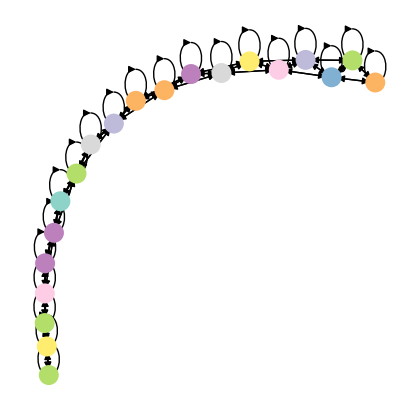

In [ ]:
def _sparse_to_graph(matrix, x_true, b):
    """Generate graph from sparse matrix system of equations."""
    return tg.data.Data(
        x=torch.tensor(b),
        edge_index=torch.tensor(np.array(matrix.nonzero())),
        edge_attr=torch.tensor(matrix.data),
        y=torch.tensor(x_true)
        )

def print_graph(graph, fig_size=(4,4)):
    """"""
    vis = to_networkx(graph)

    node_labels = graph.y.numpy()

    plt.figure(1,figsize=fig_size)
    nx.draw(vis, cmap=plt.get_cmap('Set3'), node_color = node_labels, node_size=70, linewidths=6)
    plt.show()

data_ = get_sample(number_generator, rank=20, off_diagonal_abs_mean=0.5, symmetric=False, uniform_range=(0.1,10.), log_=False)

g = _sparse_to_graph(*data_)

print(g)
for prop in g:
    print(prop)

print_graph(g)

In [79]:
import networkx as nx
# from bokeh.io import show, output_notebook
# from bokeh.plotting import figure
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, TapTool, BoxSelectTool
# from bokeh.models.graphs import from_networkx

# Enable Bokeh output in Jupyter Notebook
# output_notebook()

# Create a NetworkX graph
G = nx.karate_club_graph()

# Create a Bokeh plot
plot = Plot(plot_width=400, plot_height=400,
            x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
plot.title.text = "Networkx Graph Visualization with Bokeh"

# Add tools to the plot
plot.add_tools(HoverTool(tooltips=None), TapTool(), BoxSelectTool())

# Convert NetworkX graph to Bokeh graph renderer
graph_renderer = from_networkx(G, nx.spring_layout, scale=2, center=(0, 0))

# Add node and edge renderers
graph_renderer.node_renderer.glyph = Circle(size=15, fill_color="skyblue")
graph_renderer.edge_renderer.glyph = MultiLine(line_color="gray", line_alpha=0.8, line_width=1)

# Add the graph renderer to the plot
plot.renderers.append(graph_renderer)

# Show the plot
show(plot)

AttributeError: unexpected attribute 'plot_width' to Plot, similar attributes are outer_width, width or min_width

In [80]:
import networkx as nx

# from bokeh.palettes import Category20_20
# from bokeh.plotting import figure, from_networkx, show

G = nx.desargues_graph() # always 20 nodes

p = figure(x_range=(-2, 2), y_range=(-2, 2),
           x_axis_location=None, y_axis_location=None,
           tools="hover", tooltips="index: @index")
p.grid.grid_line_color = None

graph = from_networkx(G, nx.spring_layout, scale=1.8, center=(0,0))
p.renderers.append(graph)

# Add some new columns to the node renderer data source
graph.node_renderer.data_source.data['index'] = list(range(len(G)))
graph.node_renderer.data_source.data['colors'] = Category20_20

graph.node_renderer.glyph.update(size=20, fill_color="colors")

show(p)